# System of Equations

Let's motivate this section with  the __Lotka-Volterra equations__, also known as the predator-prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact. The populations change through time according to the pair of equations:

$$
\dfrac{dx}{dt} = \alpha x - \beta xy \\
\dfrac{dy}{dt} = -\gamma y + \delta xy
$$

where
- $x$ is the number of prey;
- $y$ is the number of some predator;
- ${\tfrac {dy}{dt}}$ and ${\tfrac {dx}{dt}}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha$, $\beta$, $\gamma$ and $\delta$ are positive real parameters describing the interaction of the two species.

## Physics-Informed Neural Networks

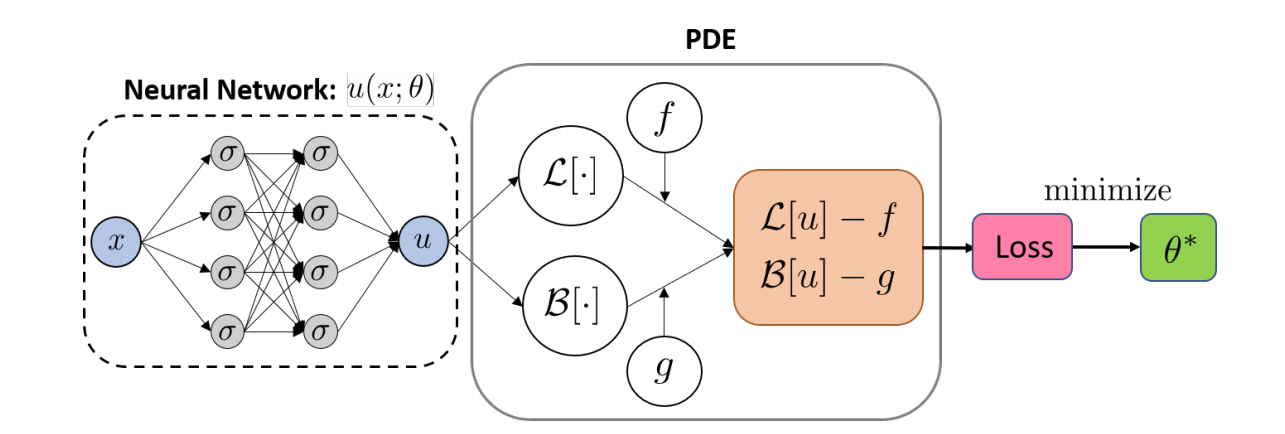

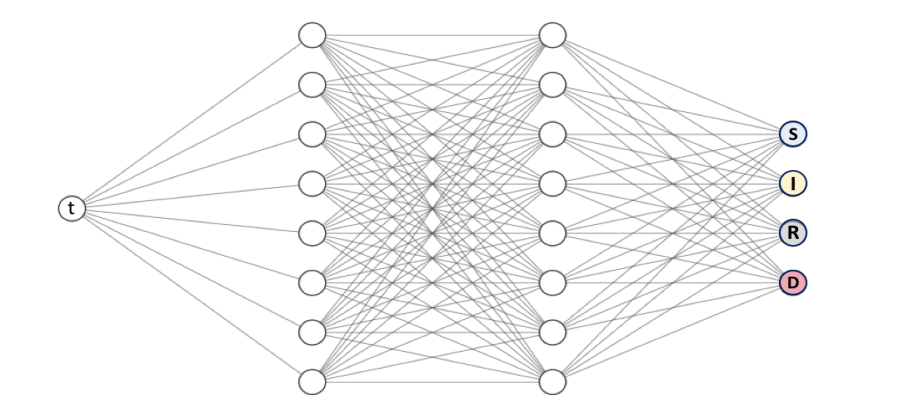

## Import packages

The most important package is `deepxde`, which allows us to implement Physic-Informed Neural Networs approaches with a few lines of code. We will need `numpy` for array operations, `matplotlib` for visualizations and `scipy` for getting the real solution (which is not always possible, if not we would only use this approach).

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

from scipy.integrate import solve_ivp
from deepxde.backend import tf

## ODE Residuals

Since we are trying to embed the physics onto the neural networks we need to define 

In [34]:
alpha = 2 / 3
beta = 4 / 3
gamma = 1
delta = 1

In [35]:
def ode(t, Y):
    x = Y[:, 0:1]
    y = Y[:, 1:2]

    dx_dt = dde.grad.jacobian(Y, t, i=0)
    dy_dt = dde.grad.jacobian(Y, t, i=1)
    
    return [
        dx_dt - alpha * x + beta * x * y,
        dy_dt + gamma * y  - delta * x * y
    ]

## Initial conditions

It is important to decide a time invertal where we will working on. As an example let's consider between $t=0$ and $t=1$.

In [36]:
t_initial = 0
t_final = 10

And now we need to declare this element for our neural network, if not, the algorithm wouldn't know where to make the estimations.

In [37]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

Then we have to create a function for defining boundaries, since our geometry it is only on time we will use the default one, don't worry about it.

In [38]:
def boundary(_, on_initial):
    return on_initial

Let's choose initial conditions for $x$ and $y$

In [39]:
x0 = 1.2
y0 = 0.8

And then we have to tell to our algorithm these are the initial conditions for the learning process

In [40]:
ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

## Data object

In [41]:
data = dde.data.PDE(
    geom,
    ode,
    [ic_x, ic_y],
    num_domain=3000,
    num_boundary=2,
    num_test = 5000
)

## Neural Network

In [42]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

## Model

In [43]:
model = dde.Model(data, net)

## Training

In [44]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)

Compiling model...
Building feed-forward neural network...
'build' took 0.039989 s



2023-02-22 17:46:02.944850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 17:46:02.944935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 17:46:02.944960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 17:46:02.945333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 17:46:02.945356: I tensorflow/core/co

'compile' took 0.271575 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.41e-03, 4.30e-01, 1.44e+00, 6.40e-01]    [7.34e-03, 4.30e-01, 1.44e+00, 6.40e-01]    []  
1000      [6.39e-04, 7.46e-04, 1.23e-06, 8.04e-06]    [6.39e-04, 7.46e-04, 1.23e-06, 8.04e-06]    []  
2000      [2.84e-04, 6.79e-04, 3.31e-07, 4.07e-06]    [2.84e-04, 6.79e-04, 3.31e-07, 4.07e-06]    []  
3000      [1.78e-04, 4.39e-04, 6.74e-08, 1.89e-06]    [1.78e-04, 4.39e-04, 6.74e-08, 1.89e-06]    []  
4000      [2.01e-05, 2.21e-05, 1.45e-06, 1.46e-06]    [1.99e-05, 2.21e-05, 1.45e-06, 1.46e-06]    []  
5000      [1.24e-05, 1.27e-05, 3.86e-06, 2.23e-07]    [1.24e-05, 1.27e-05, 3.86e-06, 2.23e-07]    []  
6000      [9.74e-06, 5.25e-06, 7.70e-06, 2.87e-08]    [9.64e-06, 5.25e-06, 7.70e-06, 2.87e-08]    []  
7000      [6.09e-05, 3.92e-05, 2.19e-05, 1.64e-11]    [6.10e-05, 3.92e-05, 2.19e-05, 1.64e-11]   

In [49]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.178866 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
50123     [7.41e-08, 5.14e-08, 2.05e-11, 1.89e-11]    [7.03e-08, 5.10e-08, 2.05e-11, 1.89e-11]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 6
  Number of functions evaluations: 74
50197     [7.30e-08, 4.95e-08, 1.88e-10, 4.54e-11]    [6.96e-08, 4.88e-08, 1.88e-10, 4.54e-11]    []  

Best model at step 50197:
  train loss: 1.23e-07
  test loss: 1.19e-07
  test metric: []

'train' took 1.817005 s



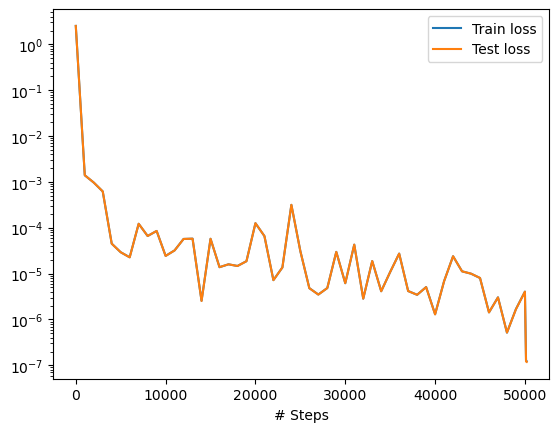

In [50]:
dde.utils.external.plot_loss_history(losshistory)

## Compare

In [47]:
def generate_data(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    x_true, y_true = sol.y
    return x_true, y_true

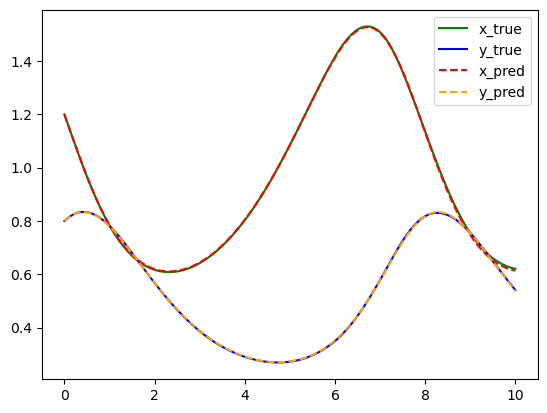

In [48]:
t = np.linspace(t_initial, t_final, 100)
x_true, y_true = generate_data(t, x0, y0, alpha, beta, gamma, delta)
plt.plot(t, x_true, color="green", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

sol_pred = model.predict(t.reshape(-1, 1))
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()